In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [2]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [3]:
# 4. Chia train test (70% train, 30% test)
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [4]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [6]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [7]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 [==============================] - 8s 160ms/step - loss: 0.0244 - val_loss: 0.0393
Epoch 2/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 3/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 4/100
14/14 [==============================] - 1s 78ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 5/100
14/14 [==============================] - 1s 103ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 6/100
14/14 [==============================] - 1s 104ms/step - loss: 0.0013 - val_loss: 0.0085
Epoch 7/100
14/14 [==============================] - 1s 78ms/step - loss: 0.0015 - val_loss: 0.0071
Epoch 8/100
14/14 [==============================] - 1s 67ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 9/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 10/100
14/14 [==============================] - 1s 66ms/step - loss: 9.7703e-04 - val_loss:

In [9]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

12/12 [==============================] - 2s 15ms/step


In [10]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [11]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 1026.4112327877415
MAPE trên tập test là: 4.062066890157718 %
MSLE trên tập test là: 0.0027250468997260546


In [12]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

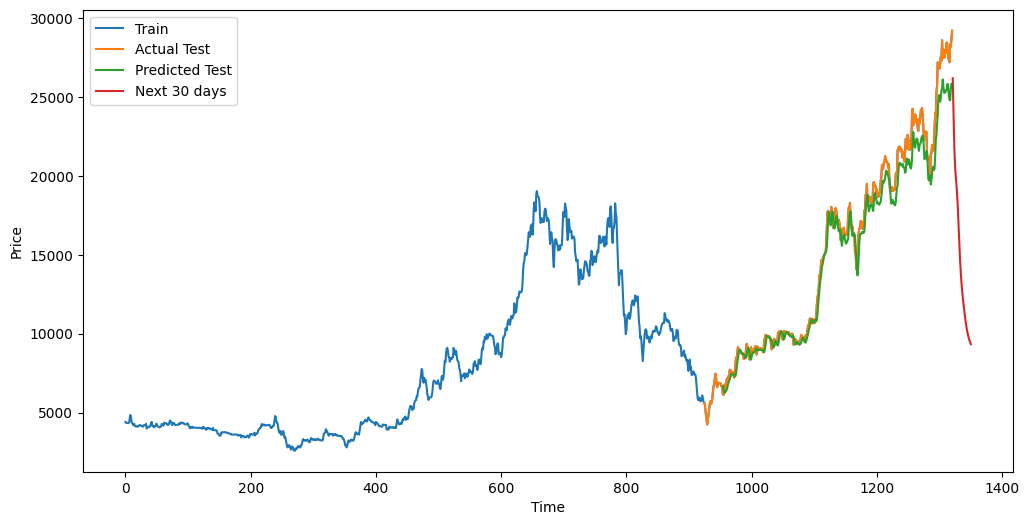

In [13]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# (Split 8/2)

In [14]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [15]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [16]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [17]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [20]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 9s 207ms/step - loss: 0.0152 - val_loss: 0.0270
Epoch 2/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 3/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0016 - val_loss: 0.0076
Epoch 4/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 5/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 6/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 7/100
17/17 [==============================] - 1s 60ms/step - loss: 9.9221e-04 - val_loss: 0.0045
Epoch 8/100
17/17 [==============================] - 1s 60ms/step - loss: 9.2386e-04 - val_loss: 0.0051
Epoch 9/100
17/17 [==============================] - 1s 58ms/step - loss: 8.6126e-04 - val_loss: 0.0097
Epoch 10/100
17/17 [==============================] - 1s 59ms/step - loss: 9.5253e-04 -

In [22]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

8/8 [==============================] - 1s 12ms/step


In [23]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [24]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 828.2748388163859
MAPE trên tập test là: 3.1716292392347785 %
MSLE trên tập test là: 0.001686561100001694


In [25]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

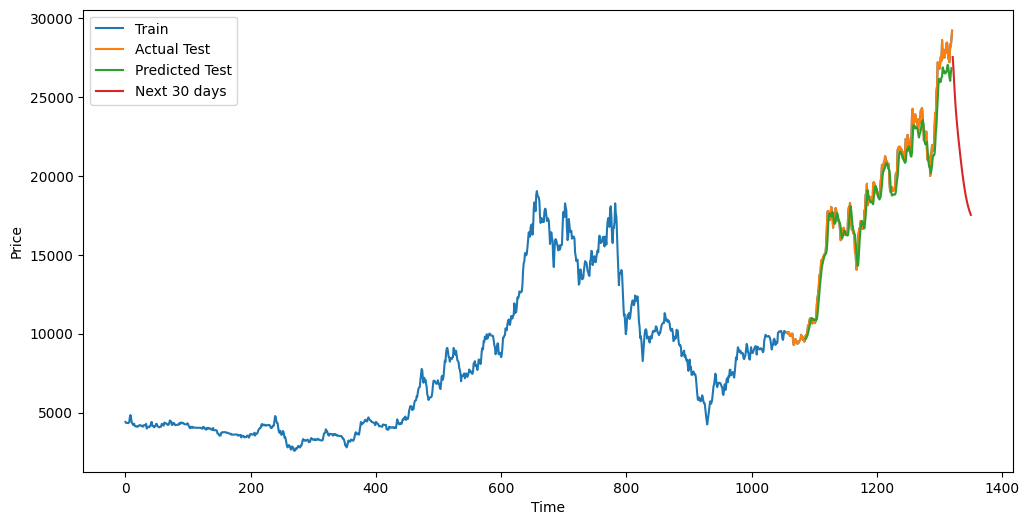

In [26]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# (Split 9/1)

In [27]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [28]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [29]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [30]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [32]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [33]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
19/19 [==============================] - 9s 136ms/step - loss: 0.0137 - val_loss: 0.0062
Epoch 2/100
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 3/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 4/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 5/100
19/19 [==============================] - 1s 59ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 6/100
19/19 [==============================] - 1s 58ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 7/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0011 - val_loss: 0.0145
Epoch 8/100
19/19 [==============================] - 1s 57ms/step - loss: 9.7566e-04 - val_loss: 0.0215
Epoch 9/100
19/19 [==============================] - 2s 83ms/step - loss: 0.0011 - val_loss: 0.0075
Epoch 10/100
19/19 [==============================] - 2s 93ms/step - loss: 9.2440e-04 - val_los

In [35]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

4/4 [==============================] - 1s 14ms/step


In [36]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [37]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 1887.5739731516087
MAPE trên tập test là: 7.124849687854351 %
MSLE trên tập test là: 0.006462067104582393


In [38]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

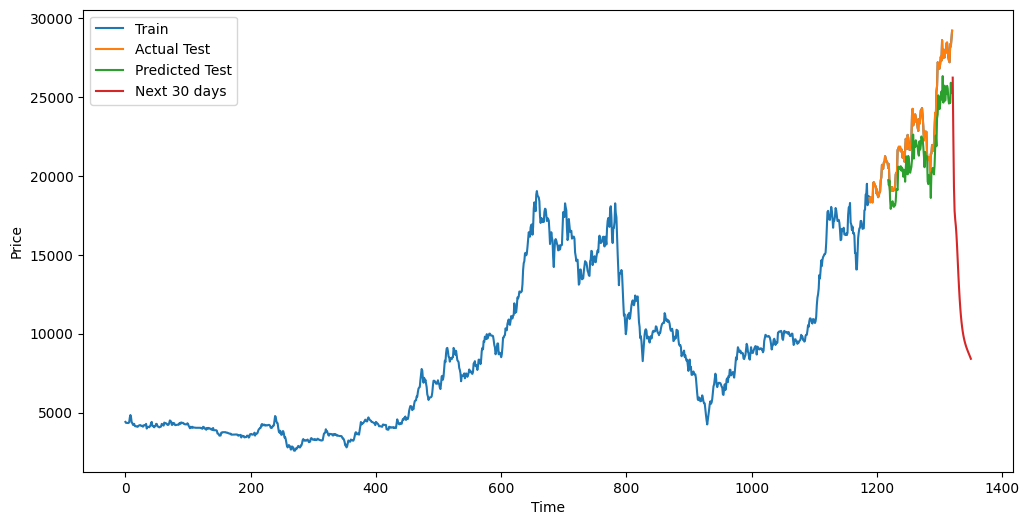

In [39]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()